## Roblox Reviews:  Binary Classification using Supervised NLP
 
Assignment 1:  Devika Pace 
 

[Import Libraries and Data](#1)

[Clean & Create Binary Classification Label](#2)

[NLP Data-Preprocessing (NLTK, Gensim)](#3)
- Clean
- Tokenize
- Stop Word Removal
- Stemming and Lemmatization

[ML Preparation - Support Functions with SciKit Learn](#4)
- Cross-Validation
- Evaluation
- Hyperparameter Tuning

[ML Pre-Processing](#5)
- Vectorization
- Train_Test Split

[Model Training & Evaluation](#6)
- Classification
- Metrics
- Selection
- Visualization
- Final Results


<a name="1"></a>
### **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from pprint import pprint

### Import Dataset - Roblox Reviews

The dataset was created utilizing parsehub to web scrape 81 pages of Roblox game reviews for a total of 1620 reviews from the [Common Sense Media](https://www.commonsensemedia.org/website-reviews/roblox) site.

In [2]:
df = pd.read_csv('roblox_80.csv', encoding='utf-8')

<a name="2"></a>
### **Clean & Create Binary Classification Label**

In [3]:
df.head()

,selection1_name,selection1_selection2,selection1_selection3
0,age 7+,There are pros and cons to this site. First of...,Adult
1,age 7+,I know what your thinking... WHY 7!!!!! I tell...,Parent of a 9-year-old
2,age 6+,My daughter plays ROBLOX all the time. I decid...,Parent of a 9-year-old
3,age 6+,i love roblox i have obc and it is fine and go...,Adult
4,age 12+,ROBLOX is a very educational game and inspires...,Adult


In [4]:
df.columns = ['recommended age', 'review', 'author']
df.shape

(1620, 3)

In [5]:
df.head()

,recommended age,review,author
0,age 7+,There are pros and cons to this site. First of...,Adult
1,age 7+,I know what your thinking... WHY 7!!!!! I tell...,Parent of a 9-year-old
2,age 6+,My daughter plays ROBLOX all the time. I decid...,Parent of a 9-year-old
3,age 6+,i love roblox i have obc and it is fine and go...,Adult
4,age 12+,ROBLOX is a very educational game and inspires...,Adult


In [6]:
df['recommended age'].value_counts()

age 18+    328
age 2+     176
age 10+    168
age 8+     166
age 7+     133
age 6+     126
age 5+      91
age 13+     88
age 9+      83
age 12+     58
age 11+     42
age 16+     41
age 4+      35
age 14+     27
age 15+     25
age 3+      18
age 17+     15
Name: recommended age, dtype: int64

In [7]:
df['age'] = df['recommended age'].apply(lambda x: int(x.split('+')[0][4:]))
df['age'].value_counts()

18    328
2     176
10    168
8     166
7     133
6     126
5      91
13     88
9      83
12     58
11     42
16     41
4      35
14     27
15     25
3      18
17     15
Name: age, dtype: int64

In [8]:
df['suitable'] = np.where(df['age']< 10,'suitable','not suitable')
df['suitable'].value_counts()

suitable        828
not suitable    792
Name: suitable, dtype: int64

In [9]:
df['review'] = df['review'].str.lower()

In [10]:
df['review'].isna().sum()

55

In [11]:
df[df['review'].isna()]['suitable'].value_counts()

not suitable    33
suitable        22
Name: suitable, dtype: int64

Drop rows without reviews.

In [12]:
df_orig = df.copy()
df = df[df['review'].notna()]
df.shape

(1565, 5)

In [13]:
¶df['suitable'].value_counts()

suitable        806
not suitable    759
Name: suitable, dtype: int64

This is a well balanced dataset of reviews.

In [14]:
df.head()

,recommended age,review,author,age,suitable
0,age 7+,there are pros and cons to this site. first of...,Adult,7,suitable
1,age 7+,i know what your thinking... why 7!!!!! i tell...,Parent of a 9-year-old,7,suitable
2,age 6+,my daughter plays roblox all the time. i decid...,Parent of a 9-year-old,6,suitable
3,age 6+,i love roblox i have obc and it is fine and go...,Adult,6,suitable
4,age 12+,roblox is a very educational game and inspires...,Adult,12,not suitable


<a name="3"></a>
### **NLP Data-Preprocessing (NLTK, Gensim)**
- Tokenize
- Stop Word Removal
- Stemming and Lemmatization


In [15]:
stemmer = SnowballStemmer('english')

def lemmatize_all(phrase):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(phrase)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        else:
            yield word

def lemmatize_stemming(text):
  return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(lemmatize_stemming(token))
    return str(result)

In [16]:
df['tokens'] = df['review'].map(preprocess)
df.head()

,recommended age,review,author,age,suitable,tokens
0,age 7+,there are pros and cons to this site. first of...,Adult,7,suitable,"['pros', 'con', 'site', 'think', 'download', '..."
1,age 7+,i know what your thinking... why 7!!!!! i tell...,Parent of a 9-year-old,7,suitable,"['know', 'think', 'tell', 'ok', 'yes', 'kill',..."
2,age 6+,my daughter plays roblox all the time. i decid...,Parent of a 9-year-old,6,suitable,"['daughter', 'play', 'roblox', 'time', 'decid'..."
3,age 6+,i love roblox i have obc and it is fine and go...,Adult,6,suitable,"['love', 'roblox', 'obc', 'fine', 'good', 'play']"
4,age 12+,roblox is a very educational game and inspires...,Adult,12,not suitable,"['roblox', 'educ', 'game', 'inspir', 'kid', 'l..."


<a name="4"></a>
### **ML Preparation - Support Functions with SciKit Learn**
- Cross-Validation
- Evaluation
- Hyperparameter Tuning



In [17]:
def crossvalidate_classifier(model, X, y, cm=False):
    skf = StratifiedKFold(n_splits=5)
    
    scores_acc = cross_val_score(model, X, y, scoring='accuracy', cv=skf)
    scores_f1 = cross_val_score(model, X, y, scoring='f1_macro', cv=skf)
    print("%0.2f Cross-validated Accuracy score with a standard deviation of %0.2f" % (scores_acc.mean(), scores_acc.std()))
    print("%0.2f Cross-validated F-1 score with a standard deviation of %0.2f" % (scores_f1.mean(), scores_f1.std()))
    y_pred = cross_val_predict(model, X, y, cv=skf)

    if(cm):
        conf_mat = confusion_matrix(y, y_pred, labels=['suitable', 'not suitable'])
        print('\nConfusion Matrix:')
        print(conf_mat)
    

def best_hyperparam(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, model_params, n_iter=10, cv=5, scoring_fit='f1_macro',
                       do_probabilities = False):
  
    gs = RandomizedSearchCV(
        estimator=model,
        param_distributions=model_params,
        n_iter=n_iter,
        scoring=scoring_fit,
        n_jobs=-1, 
        refit=True,
        cv=cv,
        verbose=2,
        random_state=33
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
  
    pprint(fitted_model.best_estimator_.get_params())

    print(f'Best Score: {fitted_model.best_score_}')
    print(f'Best Hyperparameters: {fitted_model.best_params_}')
    
    return fitted_model, pred

    
def evaluate_classifier(model, X_train, X_test, y_train, y_test, cm=True, train=False):
      
    # fit model
    if train:
        model.fit(X_train, y_train)

    # Run predict on your tfidf test data to get your predictions
    pred = model.predict(X_test)

    # Calculate your accuracy using the metrics module
    acc_score = metrics.accuracy_score(pred, y_test)
    print("Test Set Accuracy Score:   %0.3f" % acc_score)
    
    f1score = metrics.f1_score(pred, y_test, average='macro')
    print("Test Set F-1 Score:   %0.3f" % f1score)

    if cm:
      conf_mat = confusion_matrix(y_test, pred, labels=['suitable', 'not suitable'])
      print('\nConfusion Matrix:')
      print(conf_mat)
    
    return model


<a name="5"></a>
### **ML Pre-Processing**
- Train_Test Split
- Vectorization



In [18]:
X = df['tokens']
y = df['suitable']

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.25, shuffle=True, stratify=y )

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
max_df = 0.95
min_df = 0.05

# Initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words='english', max_df=max_df, min_df=min_df)

# Create count train and test variables
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=max_df, min_df=min_df)

# Create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [21]:
print(count_train.shape, tfidf_train.shape)

(1173, 115) (1173, 115)


In [22]:
print(count_vectorizer.vocabulary_)

{'swear': 93, 'roblox': 77, 'game': 35, 'kid': 44, 'spend': 89, 'play': 69, 'start': 90, 'content': 22, 'inappropri': 43, 'thing': 97, 'son': 88, 'year': 113, 'fun': 34, 'buy': 14, 'robux': 78, 'chat': 17, 'turn': 101, 'moder': 57, 'make': 54, 'report': 75, 'work': 112, 'parent': 65, 'help': 41, 'ban': 8, 'problem': 71, 'good': 36, 'age': 3, 'daughter': 26, 'scam': 82, 'onlin': 63, 'say': 81, 'peopl': 66, 'mean': 55, 'tell': 96, 'real': 73, 'app': 5, 'monitor': 59, 'children': 19, 'recommend': 74, 'bad': 7, 'know': 45, 'think': 98, 'saw': 80, 'child': 18, 'watch': 108, 'person': 67, 'review': 76, 'like': 49, 'safe': 79, 'block': 10, 'number': 61, 'violenc': 105, 'hack': 38, 'way': 109, 'word': 111, 'let': 47, 'blood': 11, 'happen': 40, 'free': 32, 'currenc': 24, 'overal': 64, 'time': 99, 'sex': 85, 'want': 107, 'filter': 31, 'read': 72, 'need': 60, 'charact': 16, 'allow': 4, 'look': 51, 'build': 12, 'old': 62, 'sexual': 86, 'creat': 23, 'sure': 92, 'set': 84, 'dont': 29, 'communiti': 2

<a name="6"></a>
### Model Training & Evaluation 
- Classification
- Metrics
- Selection
- Visualization
- Final Results

Try Random Forest, Ada Boost, Bagging, and Gradient Boosting Classifiers.

In [23]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier

### **TF-IDF Vectorized Performance**


In [24]:
crossvalidate_classifier(RandomForestClassifier(), tfidf_train, y_train, cm=True)

0.63 Cross-validated Accuracy score with a standard deviation of 0.02
0.63 Cross-validated F-1 score with a standard deviation of 0.02

Confusion Matrix:
[[392 212]
 [237 332]]


In [25]:
crossvalidate_classifier(AdaBoostClassifier(), tfidf_train, y_train, cm=True)

0.60 Cross-validated Accuracy score with a standard deviation of 0.02
0.60 Cross-validated F-1 score with a standard deviation of 0.02

Confusion Matrix:
[[399 205]
 [260 309]]


In [26]:
crossvalidate_classifier(BaggingClassifier(), tfidf_train, y_train, cm=True)

0.58 Cross-validated Accuracy score with a standard deviation of 0.03
0.60 Cross-validated F-1 score with a standard deviation of 0.02

Confusion Matrix:
[[323 281]
 [212 357]]


In [27]:
crossvalidate_classifier(GradientBoostingClassifier(), tfidf_train, y_train, cm=True)

0.62 Cross-validated Accuracy score with a standard deviation of 0.04
0.62 Cross-validated F-1 score with a standard deviation of 0.04

Confusion Matrix:
[[409 195]
 [255 314]]


#### Hyperparameter Tuning for Best Model - Random Forest Classifier (TF-IDF)

Choosing Random Forest Model based on highest F-1 score in cross-validation.

In [28]:
from scipy.stats import uniform, truncnorm, randint
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [50,100,200,300],
    'max_depth': [5, 10, 20, 30],        
}
model_params = {
    # randomly sample numbers from 4 to 200 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, with mean loc, stddev scale, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.90, scale=0.1),
    # uniform distribution from 0.01 to 0.25 (0.01 + 0.24)
    'min_samples_split': uniform(0.01, 0.24),
}

best_model_tfidf, bm_pred = best_hyperparam(tfidf_train, tfidf_test, y_train, y_test, 
                       model, model_params, cv=5, scoring_fit='f1_macro',
                       do_probabilities = False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.9214259437976595,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 0.11799410105219091,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
Best Score: 0.6327055468812857
Best Hyperparameters: {'max_features': 0.9214259437976595, 'min_samples_split': 0.11799410105219091, 'n_estimators': 150}


In [29]:
evaluate_classifier(best_model_tfidf, tfidf_train, tfidf_test, y_train, y_test)

Test Set Accuracy Score:   0.645
Test Set F-1 Score:   0.645

Confusion Matrix:
[[133  69]
 [ 70 120]]


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5c68285e20>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5c2b0cfbe0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5c2626b4f0>},
                   random_state=33, scoring='f1_macro', verbose=2)

#### Tuned Best Model - Random Forest - TF-IDF Vectorization

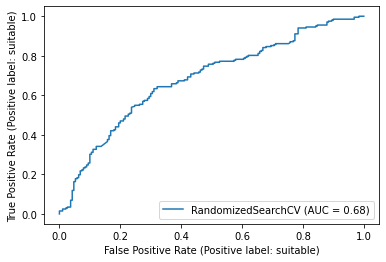

In [30]:
from sklearn.metrics import RocCurveDisplay
best_model_disp_tfidf = RocCurveDisplay.from_estimator(best_model_tfidf, tfidf_test, y_test)

### **Count Vectorized Performance**

In [31]:
crossvalidate_classifier(RandomForestClassifier(), count_train, y_train, cm=True)

0.61 Cross-validated Accuracy score with a standard deviation of 0.03
0.59 Cross-validated F-1 score with a standard deviation of 0.02

Confusion Matrix:
[[351 253]
 [214 355]]


In [32]:
crossvalidate_classifier(AdaBoostClassifier(), count_train, y_train, cm=True)

0.61 Cross-validated Accuracy score with a standard deviation of 0.03
0.61 Cross-validated F-1 score with a standard deviation of 0.03

Confusion Matrix:
[[411 193]
 [263 306]]


In [33]:
crossvalidate_classifier(BaggingClassifier(), count_train, y_train, cm=True)

0.56 Cross-validated Accuracy score with a standard deviation of 0.01
0.56 Cross-validated F-1 score with a standard deviation of 0.02

Confusion Matrix:
[[311 293]
 [228 341]]


In [34]:
crossvalidate_classifier(GradientBoostingClassifier(), count_train, y_train, cm=True)

0.62 Cross-validated Accuracy score with a standard deviation of 0.04
0.61 Cross-validated F-1 score with a standard deviation of 0.03

Confusion Matrix:
[[427 177]
 [278 291]]


#### Hyperparameter Tuning Random Forest - To Compare with TF-IDF

In [35]:
best_model_count, bm_pred = best_hyperparam(count_train, count_test, y_train, y_test, 
                       model, model_params, cv=5, scoring_fit='f1_macro',
                       do_probabilities = False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.9719873299947277,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 0.05981259576579324,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 135,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
Best Score: 0.6273633955373381
Best Hyperparameters: {'max_features': 0.9719873299947277, 'min_samples_split': 0.05981259576579324, 'n_estimators': 135}


In [36]:
evaluate_classifier(best_model_count, count_train, count_test, y_train, y_test)

Test Set Accuracy Score:   0.666
Test Set F-1 Score:   0.665

Confusion Matrix:
[[140  62]
 [ 69 121]]


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5c68285e20>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5c2b0cfbe0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5c2626b4f0>},
                   random_state=33, scoring='f1_macro', verbose=2)

#### Tuned Random Forest - Count Vectorization

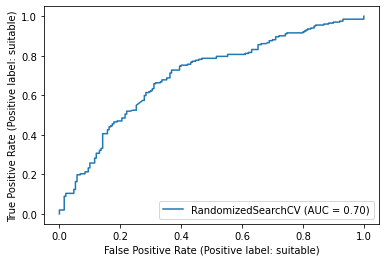

In [43]:
best_model_disp_count = RocCurveDisplay.from_estimator(best_model_count, count_test, y_test);

#### Hyperparameter Tuning for Best Model - Gradient Boosting 

In [38]:
model = GradientBoostingClassifier()
best_model_count_gbc, bm_pred = best_hyperparam(count_train, count_test, y_train, y_test, 
                       model, model_params, cv=5, scoring_fit='f1_macro',
                       do_probabilities = False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 0.9214259437976595,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 0.11799410105219091,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
Best Score: 0.6254901025683403
Best Hyperparameters: {'max_features': 0.9214259437976595, 'min_samples_split': 0.11799410105219091, 'n_estimators': 150}


In [39]:
evaluate_classifier(best_model_count_gbc, count_train, count_test, y_train, y_test)

Test Set Accuracy Score:   0.676
Test Set F-1 Score:   0.672

Confusion Matrix:
[[153  49]
 [ 78 112]]


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5c68285e20>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5c2b0cfbe0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5c2626b4f0>},
                   random_state=33, scoring='f1_macro', verbose=2)

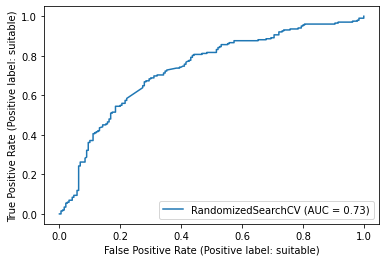

In [41]:
best_model_disp_count_gbc = RocCurveDisplay.from_estimator(best_model_count_gbc, count_test, y_test);

### Conclusion

Our best model is the count vectorized dataset with tuned hyperparameters for the Gradient Boosting classifier.  We have a relatively large dataset, given reviews per game, which is quite well balanced such that F-1 score is very close to accuracy.